### HELLO!!!
You decided to read my code for some reason. Well, that was your mistake...
I wish you luck on this fool hardy quest of yours brave soul!

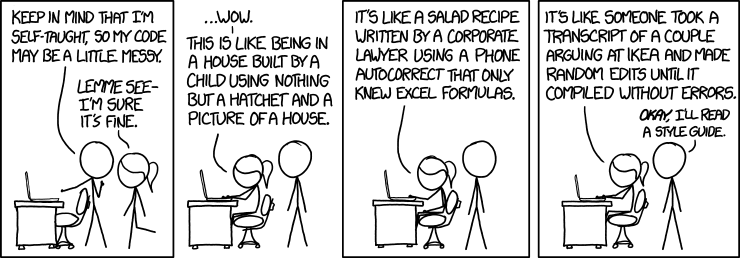

In [1]:
#Imports are important
import ccdproc 
import os
import numpy as np
import pandas as pd
from astropy.io import fits
from glob import glob
from astropy.io import fits
import astroalign as aa
from ccdproc import CCDData, combine, subtract_bias, flat_correct
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
bandFilter = 'B'


Always know your enemy...

In [2]:

from astropy.io import fits

# Path to your FITS file
fits_file_path = "Trip1Data/20230701/ecam-0115.fits"

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    header = hdul[0].header
    for key, value in header.items():
        print(f"{key}: {value}")


SIMPLE: True
BITPIX: 64
NAXIS: 2
NAXIS1: 1024
NAXIS2: 1024
EXTEND: True
DATE-OBS: 2023-07-01T08:17:18.195
EXP_TIME: 30.0
EXP_TYPE: Single
IMG_TYPE: Object
FILTER: B
TEMP: -81.19
COMMENT: 7/1 landolt


There is no orginasation here, this was iteritve and bahsed togheter. It's more like ancient ruins of attmepts at gettign code to work.

In [3]:
from glob import glob
from astropy.io import fits

def filter_files_by_header(files, header_key, header_values, band=None, comment_contains=None, comment_excludes=None, exclude_numbers=None, exclude_ranges=None):
    filtered_files = []
    for file in files:
        file_number = int(file.split('-')[-1].split('.')[0])
        
        # Check for excluded numbers
        if exclude_numbers and file_number in exclude_numbers:
            continue
        
        # Check for excluded ranges
        if exclude_ranges:
            in_excluded_range = any(start <= file_number <= end for start, end in exclude_ranges)
            if in_excluded_range:
                continue
        
        with fits.open(file) as hdul:
            if hdul[0].header.get(header_key) in header_values:
                if band is None or hdul[0].header.get('FILTER') == band:
                    comments = [card[1] for card in hdul[0].header.cards if card[0] == 'COMMENT']
                    
                    # Convert comment_contains to a list if it's a string
                    comment_contains_list = [comment_contains] if isinstance(comment_contains, str) else comment_contains
                    
                    if comment_contains_list is None or any(item.lower() in comment.lower() for item in comment_contains_list for comment in comments):
                        if comment_excludes is None or not any(exclude.lower() in comment.lower() for exclude in comment_excludes for comment in comments):
                            filtered_files.append(file)
                            print(f"File: {file}, Comments: {comments}")
    return filtered_files

def load_and_filter_files(directory, header_key, header_values, band=None, comment_contains=None, comment_excludes=None, exclude_numbers=None, exclude_ranges=None):
    all_files = glob(f'{directory}/*.fits')
    return filter_files_by_header(all_files, header_key, header_values, band, comment_contains, comment_excludes, exclude_numbers, exclude_ranges)


In [4]:

# For flats
flat_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"], exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
flat_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
flat_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files = flat_files_1 + flat_files_2+ flat_files_3+flat_files_4+flat_files_5+flat_files_6+flat_files_7+flat_files_8
flat_list = [CCDData.read(file, unit="adu") for file in flat_files]


# For bias
bias_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Bias'], bandFilter)
bias_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Bias'], bandFilter, exclude_numbers=[1,43, 54,60,72], exclude_ranges=[(43, 54),(60,72)])
bias_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Bias'], bandFilter)#, comment_contains="Dome", comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
bias_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Bias'], bandFilter)#, comment_contains="Dome", comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
bias_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Bias'], bandFilter)#, comment_contains="Dome", comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
bias_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Bias'], bandFilter)#, comment_contains="Dome", comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
bias_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Bias'], bandFilter,exclude_numbers=[1])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
bias_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Bias'], bandFilter)#, comment_contains="Dome", comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
bias_files = bias_files_1 + bias_files_2+ bias_files_3+bias_files_4+bias_files_5+bias_files_6+bias_files_7+bias_files_8
bias_list = [CCDData.read(file, unit="adu") for file in bias_files]

# Create master bias
if bias_list:
    master_bias = combine(bias_list, method='average')
else:
    raise ValueError("No bias images found!")

# Create master flat

if flat_list:
    master_flat = combine(flat_list, method='average')
else:
    raise ValueError("No flat images found!")


File: Trip1Data/20230630/ecam-0068.fits, Comments: ['06/30 Dome flat B 55s']
File: Trip1Data/20230630/ecam-0067.fits, Comments: ['06/30 Dome flat B 50s']
File: Trip1Data/20230630/ecam-0058.fits, Comments: ['06/30 Dome flat B 26s']
File: Trip1Data/20230630/ecam-0066.fits, Comments: ['06/30 Dome flat B 45s']
File: Trip1Data/20230630/ecam-0069.fits, Comments: ['06/30 Dome flat B 42s']
File: Trip1Data/20230630/ecam-0063.fits, Comments: ['06/30 Dome flat B 36s']
File: Trip1Data/20230630/ecam-0054.fits, Comments: ['06/30 Dome flat B 15s']
File: Trip1Data/20230630/ecam-0062.fits, Comments: ['06/30 Dome flat B 34s']
File: Trip1Data/20230630/ecam-0065.fits, Comments: ['06/30 Dome flat B 40s']
File: Trip1Data/20230630/ecam-0056.fits, Comments: ['06/30 Dome flat B 22s']
File: Trip1Data/20230630/ecam-0052.fits, Comments: ['06/30 Dome flat B 5s']
File: Trip1Data/20230630/ecam-0059.fits, Comments: ['06/30 Dome flat B 28s']
File: Trip1Data/20230630/ecam-0064.fits, Comments: ['06/30 Dome flat B 38s']


File: Trip1Data/20230630/ecam-0010.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0004.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0005.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0006.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0007.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0002.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0003.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0008.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0001.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230630/ecam-0009.fits, Comments: ['06/30 Bias']
File: Trip1Data/20230701/ecam-0081.fits, Comments: ['7/1 bias']
File: Trip1Data/20230701/ecam-0077.fits, Comments: ['7/1 bias']
File: Trip1Data/20230701/ecam-0073.fits, Comments: ['7/1 bias']
File: Trip1Data/20230701/ecam-0080.fits, Comments: ['7/1 bias']
File: Trip1Data/20230701/ecam-0074.fits, Comments: ['7/1 bias']
File: Trip1Data/2023

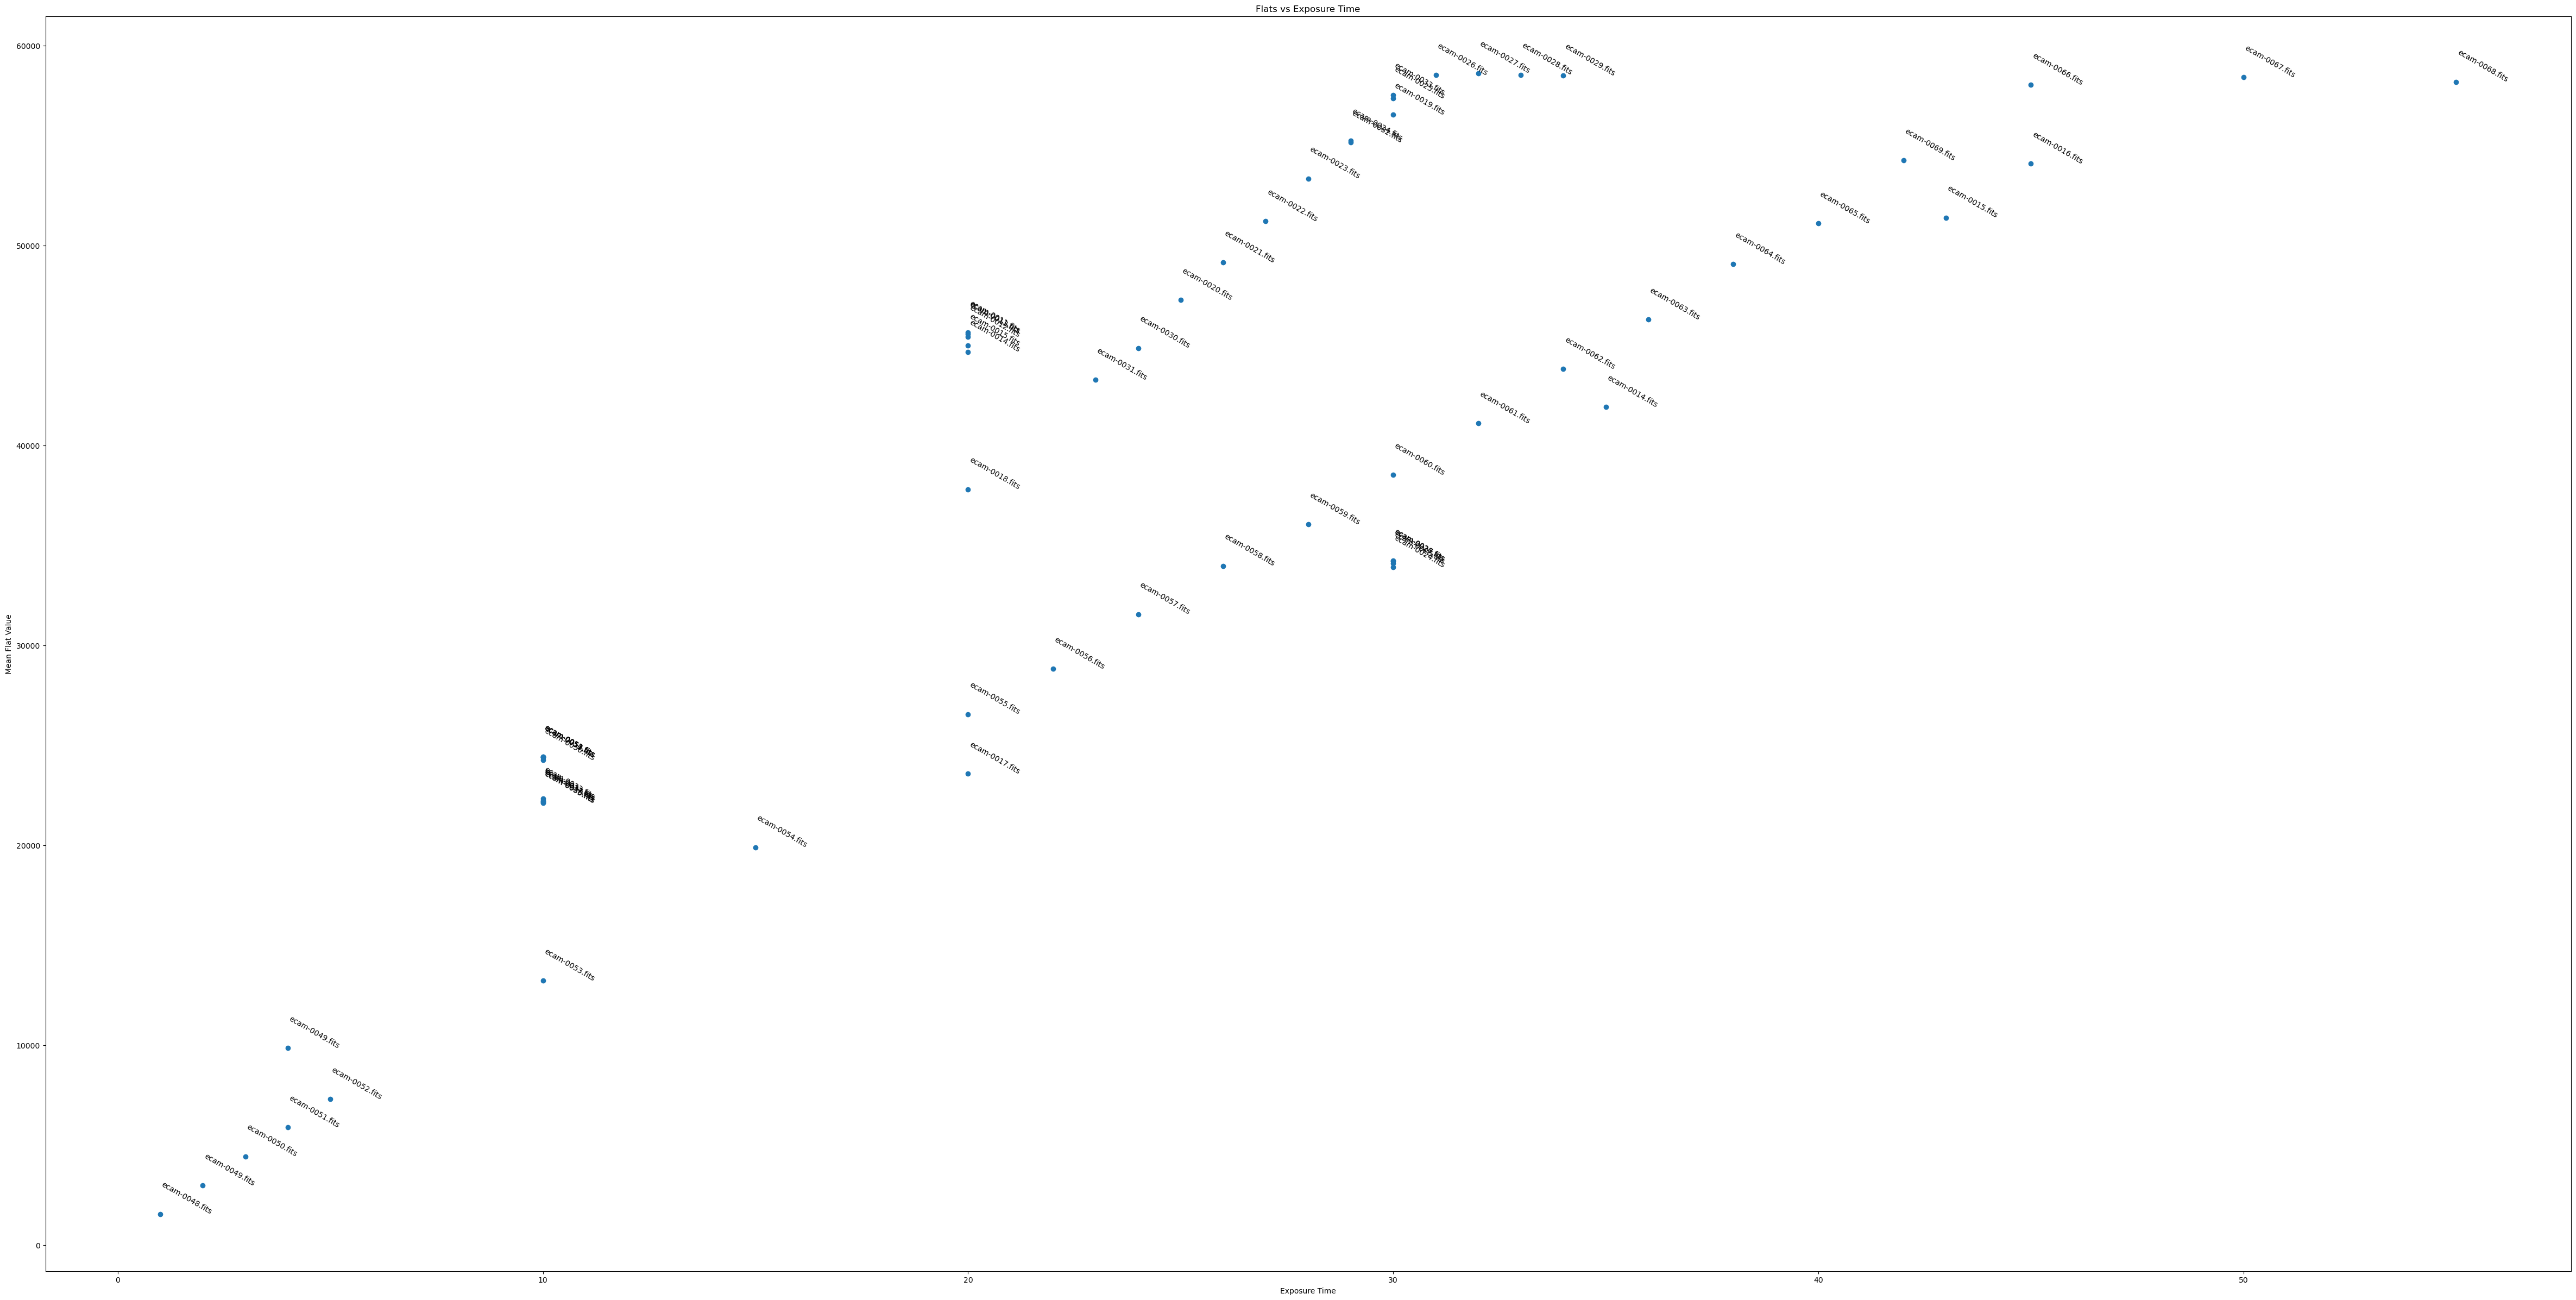

In [5]:
if flat_list:
    flat_list = [subtract_bias(flat, master_bias) for flat in flat_list]
    master_flat = combine(flat_list, method='average')
else:
    print(f"No flat images with 'dome' in COMMENT found for band {bandFilter}!")

# Flats vs Exposure Time plot
exposure_times = [fits.getheader(file)['EXP_TIME'] for file in flat_files]
flat_means = [np.mean(flat) for flat in flat_list]

plt.figure(figsize=(60, 30))
plt.plot(exposure_times, flat_means, 'o')
plt.xlabel('Exposure Time')
plt.ylabel('Mean Flat Value')
plt.title('Flats vs Exposure Time')

# Annotate each data point with its filename
for i, file in enumerate(flat_files):
    plt.annotate(os.path.basename(file), (exposure_times[i], flat_means[i]), rotation=-30)

plt.show()

In [6]:
def exclude_above_slope(x, y, slope, intercept):
    """
    Exclude points above and to the left of a given slope.
    """
    return [point for point in zip(x, y) if point[1] <= slope * point[0] + intercept]

# Define the slope and intercept of the diagonal line
slope = 1250  # Adjust as needed
intercept = 3000  # Adjust as needed

def exclude_below_slope_with_cutoff(x, y, slope, intercept, x_cutoff):
    """
    Exclude points below and to the right of a given slope, but include all points with x-values greater than x_cutoff.
    """
    return [point for point in zip(x, y) if point[0] > x_cutoff or point[1] >= slope * point[0] + intercept]

# usage:
slope2 = 1250  # Adjust as needed
intercept2 = -900  # Adjust as needed
x_cutoff = 45  # Adjust as needed

filtered_data = exclude_below_slope_with_cutoff(exposure_times, flat_means, slope2, intercept2, x_cutoff)

filtered_exposure_times, filtered_flat_means = zip(*filtered_data)


# Exclude points above and to the left of the given slope
filtered_data = exclude_above_slope(filtered_exposure_times, filtered_flat_means, slope, intercept)
filtered_exposure_times, filtered_flat_means = zip(*filtered_data)


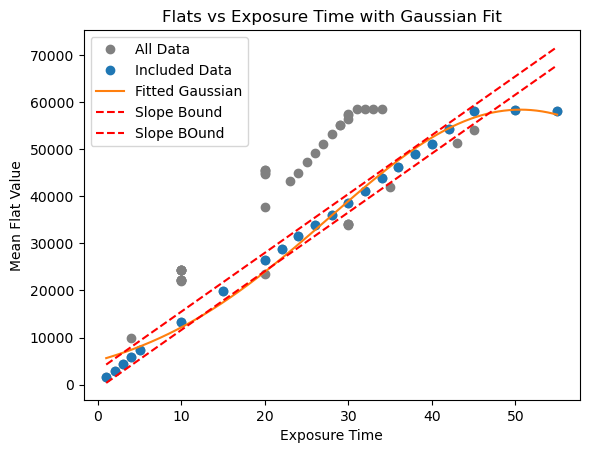

In [7]:
from scipy.optimize import curve_fit


def gaussian(x, a, x0, sigma):
    """
    Gaussian function.
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))


# Initial guess for the parameters (amplitude, mean, standard deviation)
p0 = [max(filtered_flat_means), np.mean(filtered_exposure_times), np.std(filtered_exposure_times)]

# Fit the Gaussian function to the filtered data
popt, _ = curve_fit(gaussian, filtered_exposure_times, filtered_flat_means, p0=p0)

# Generate x values for plotting the fitted function
x_fit = np.linspace(min(filtered_exposure_times), max(filtered_exposure_times), 100000)
y_fit = gaussian(x_fit, *popt)

# Plot the original data, excluded points, and the fitted Gaussian curve
plt.plot(exposure_times, flat_means, 'o', label='All Data', color='gray')
plt.plot(filtered_exposure_times, filtered_flat_means, 'o', label='Included Data')
plt.plot(x_fit, y_fit, '-', label='Fitted Gaussian')

# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, '--', color='red', label='Slope Bound')

# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope2 * x_vals + intercept2
plt.plot(x_vals, y_vals, '--', color='red', label='Slope BOund')


plt.xlabel('Exposure Time')
plt.ylabel('Mean Flat Value')
plt.title('Flats vs Exposure Time with Gaussian Fit')
plt.legend()
plt.show()


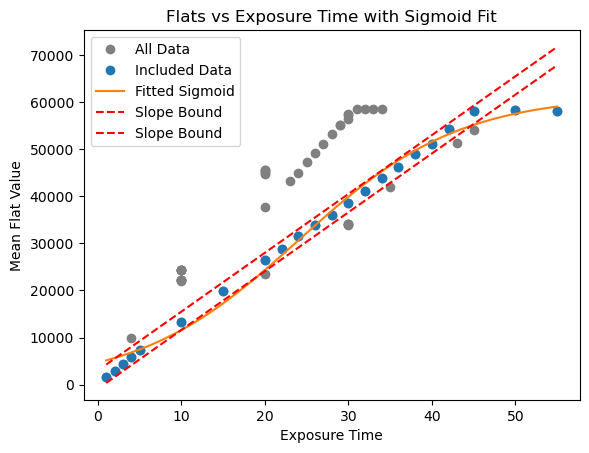

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Your data
exposure_times = [fits.getheader(file)['EXP_TIME'] for file in flat_files]
flat_means = [np.mean(flat) for flat in flat_list]

# Initial guesses
L0 = max(filtered_flat_means)
x0 = np.median(filtered_exposure_times)
k0 = 1

# Fit the sigmoid function to your data
params, _ = curve_fit(sigmoid, filtered_exposure_times, filtered_flat_means, p0=[L0, x0, k0], bounds=(0, [2*L0, 2*x0, 1000]))

# Generate the fitted sigmoid curve
x_fit = np.linspace(min(filtered_exposure_times), max(filtered_exposure_times), 1000)
y_fit = sigmoid(x_fit, *params)

# Plot the original data, excluded points, and the fitted sigmoid curve
plt.plot(exposure_times, flat_means, 'o', label='All Data', color='gray')
plt.plot(filtered_exposure_times, filtered_flat_means, 'o', label='Included Data')
plt.plot(x_fit, y_fit, '-', label='Fitted Sigmoid')
# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, '--', color='red', label='Slope Bound')

# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope2 * x_vals + intercept2
plt.plot(x_vals, y_vals, '--', color='red', label='Slope Bound')

plt.xlabel('Exposure Time')
plt.ylabel('Mean Flat Value')
plt.title('Flats vs Exposure Time with Sigmoid Fit')
plt.legend()
plt.show()


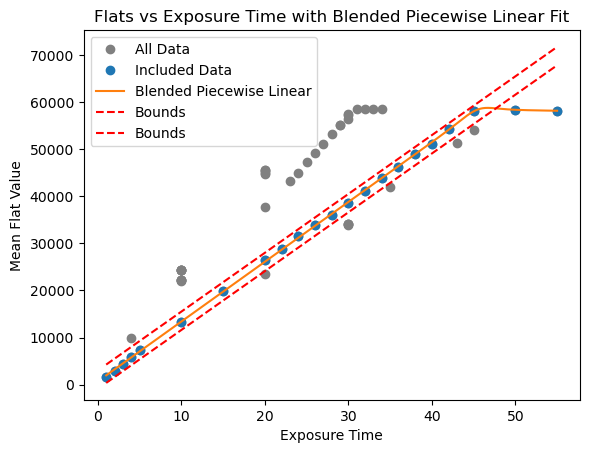

Fitted Equation:

y(x) = ((1 - (1 / (1 + exp(-1.01 * (x - 45.58)))))) * (1269.62 * x + 689.42)
       + ((1 / (1 + exp(-1.01 * (x - 45.58)))) * (-27.91 * (x - 45.58) + 58448.63))



In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the blended piecewise function
def blended_piecewise(x, m1, m2, b1, x_break, y_break, k):
    f1 = m1 * x + b1
    f2 = m2 * (x - x_break) + y_break
    s = 1 / (1 + np.exp(-k * (x - x_break)))
    return (1 - s) * f1 + s * f2

# Your data
exposure_times = [fits.getheader(file)['EXP_TIME'] for file in flat_files]
flat_means = [np.mean(flat) for flat in flat_list]

# Your provided initial guesses
m1 = 1250
m2 = -100
b1 = 200
x_break = 40
y_break = m1 * x_break + b1
k = 1  # steepness of the sigmoid transition

# Fit the blended piecewise function to your data
params, _ = curve_fit(blended_piecewise, filtered_exposure_times, filtered_flat_means, p0=[m1, m2, b1, x_break, y_break, k])

# Generate the fitted curve
x_fit = np.linspace(min(filtered_exposure_times), max(filtered_exposure_times), 1000)
y_fit = blended_piecewise(x_fit, *params)

# Plot the original data, excluded points, and the fitted curve
plt.plot(exposure_times, flat_means, 'o', label='All Data', color='gray')
plt.plot(filtered_exposure_times, filtered_flat_means, 'o', label='Included Data')
plt.plot(x_fit, y_fit, '-', label='Blended Piecewise Linear')

# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, '--', color='red', label='Bounds')

# Plot the slope cutoff
x_vals = np.linspace(min(exposure_times), max(exposure_times), 100)
y_vals = slope2 * x_vals + intercept2
plt.plot(x_vals, y_vals, '--', color='red', label='Bounds')

plt.xlabel('Exposure Time')
plt.ylabel('Mean Flat Value')
plt.title('Flats vs Exposure Time with Blended Piecewise Linear Fit')
plt.legend()
plt.show()

# Extract the optimized parameters
m1_opt, m2_opt, b1_opt, x_break_opt, y_break_opt, k_opt = params

# Construct the equation string
equation_str = f"""
y(x) = ((1 - (1 / (1 + exp(-{k_opt:.2f} * (x - {x_break_opt:.2f})))))) * ({m1_opt:.2f} * x + {b1_opt:.2f})
       + ((1 / (1 + exp(-{k_opt:.2f} * (x - {x_break_opt:.2f})))) * ({m2_opt:.2f} * (x - {x_break_opt:.2f}) + {y_break_opt:.2f}))
"""

print("Fitted Equation:")
print(equation_str)


## HAHA! ONWARDS! 

File: Trip1Data/20230630/ecam-0068.fits, Comments: ['06/30 Dome flat B 55s']
File: Trip1Data/20230630/ecam-0067.fits, Comments: ['06/30 Dome flat B 50s']
File: Trip1Data/20230630/ecam-0058.fits, Comments: ['06/30 Dome flat B 26s']
File: Trip1Data/20230630/ecam-0066.fits, Comments: ['06/30 Dome flat B 45s']
File: Trip1Data/20230630/ecam-0069.fits, Comments: ['06/30 Dome flat B 42s']
File: Trip1Data/20230630/ecam-0063.fits, Comments: ['06/30 Dome flat B 36s']
File: Trip1Data/20230630/ecam-0054.fits, Comments: ['06/30 Dome flat B 15s']
File: Trip1Data/20230630/ecam-0062.fits, Comments: ['06/30 Dome flat B 34s']
File: Trip1Data/20230630/ecam-0065.fits, Comments: ['06/30 Dome flat B 40s']
File: Trip1Data/20230630/ecam-0056.fits, Comments: ['06/30 Dome flat B 22s']
File: Trip1Data/20230630/ecam-0052.fits, Comments: ['06/30 Dome flat B 5s']
File: Trip1Data/20230630/ecam-0059.fits, Comments: ['06/30 Dome flat B 28s']
File: Trip1Data/20230630/ecam-0064.fits, Comments: ['06/30 Dome flat B 38s']


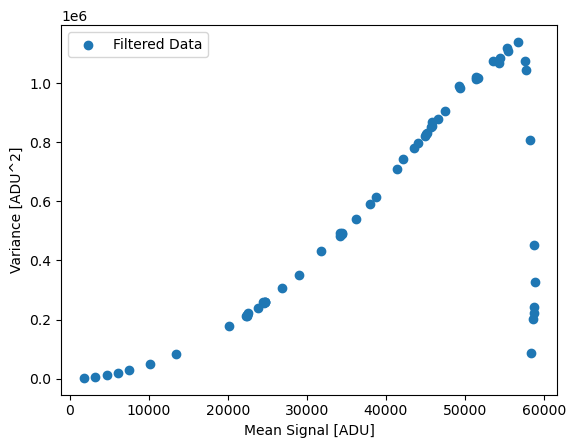

Gain: 1.24 e-/ADU


In [10]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# For flats
flat_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"], exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
flat_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
flat_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files = flat_files_1 + flat_files_2+ flat_files_3+flat_files_4+flat_files_5+flat_files_6+flat_files_7+flat_files_8
flat_list = [CCDData.read(file, unit="adu") for file in flat_files]

flat_means = []
flat_variances = []

# Calculate mean and variance for each flat file
for file in flat_files:
    data = fits.getdata(file)
    flat_means.append(np.mean(data))
    flat_variances.append(np.var(data))

# Filter the data using the provided functions
filtered_data = exclude_below_slope_with_cutoff(flat_means, flat_variances, slope2, intercept2, x_cutoff)
filtered_flat_means, filtered_flat_variances = zip(*filtered_data)
filtered_data = exclude_above_slope(filtered_flat_means, filtered_flat_variances, slope, intercept)
filtered_flat_means, filtered_flat_variances = zip(*filtered_data)

# Odd number of biases, this compensates for that
num_pairs = min(len(flat_files), len(bias_files)) // 2

# Calculate gain using the filtered data
differences = []
for i in range(0, num_pairs * 2, 2):
    flat_data1 = fits.getdata(flat_files[i])
    flat_data2 = fits.getdata(flat_files[i+1])
    bias_data1 = fits.getdata(bias_files[i])
    bias_data2 = fits.getdata(bias_files[i+1])

    mean_diff_flat = np.mean(flat_data1) + np.mean(flat_data2)
    mean_diff_bias = np.mean(bias_data1) + np.mean(bias_data2)
    sigma_flat = np.std(flat_data1 - flat_data2)
    sigma_bias = np.std(bias_data1 - bias_data2)

    gain = (mean_diff_flat - mean_diff_bias) / (sigma_flat**2 - sigma_bias**2)
    differences.append(gain)

gain = np.mean(differences)

# Plotting and printing results
plt.scatter(filtered_flat_means, filtered_flat_variances, label='Filtered Data')
plt.xlabel('Mean Signal [ADU]')
plt.ylabel('Variance [ADU^2]')
plt.legend()
plt.show()

print(f"Gain: {gain:.2f} e-/ADU")


In [11]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Load specific flat and bias files using the load_and_filter_files function
flat_file1 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"],exclude_numbers=[25, 27], exclude_ranges=[(0, 25),(27, 143)])[0]
flat_file2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Dome"], comment_excludes=["check", "parked"],exclude_numbers=[26, 28], exclude_ranges=[(0, 26),(28, 143)])[0]
bias_file1 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Bias'], bandFilter, comment_contains=["Bias"], comment_excludes=["check", "parked"],exclude_numbers=[75, 77], exclude_ranges=[(0, 75),(77, 143)])[0]
bias_file2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Bias'], bandFilter, comment_contains=["Bias"], comment_excludes=["check", "parked"],exclude_numbers=[76, 78], exclude_ranges=[(0, 76),(78, 143)])[0]

# Load the data from the files
flat_data1 = fits.getdata(flat_file1)
flat_data2 = fits.getdata(flat_file2)
bias_data1 = fits.getdata(bias_file1)
bias_data2 = fits.getdata(bias_file2)

# Calculate the mean differences and sigma values
mean_diff_flat = np.mean(flat_data1) + np.mean(flat_data2)
mean_diff_bias = np.mean(bias_data1) + np.mean(bias_data2)
sigma_flat = np.std(flat_data1 - flat_data2)
sigma_bias = np.std(bias_data1 - bias_data2)

# Calculate the gain
gain = (mean_diff_flat - mean_diff_bias) / (sigma_flat**2 - sigma_bias**2)

# Print the result
print(f"Gain: {gain:.2f} e-/ADU")


File: Trip1Data/20230701/ecam-0026.fits, Comments: ['7/1 Dome Flat']
File: Trip1Data/20230701/ecam-0027.fits, Comments: ['7/1 Dome Flat']
File: Trip1Data/20230701/ecam-0076.fits, Comments: ['7/1 bias']
File: Trip1Data/20230701/ecam-0077.fits, Comments: ['7/1 bias']
Gain: 1.57 e-/ADU


In [12]:


print(len(bias_files))
differences = []

# Calculate the difference between pairs of bias frames
for i in range(0, len(bias_files) - 1, 2):  # Subtract 1 from the length to avoid out-of-range index
    data1 = fits.getdata(bias_files[i])
    data2 = fits.getdata(bias_files[i+1])
    differences.append(data1 - data2)

# Calculate the standard deviation of these differences
std_devs = [np.std(diff) for diff in differences]
read_noise_adu = np.mean(std_devs) / np.sqrt(2)

# Convert to electrons
read_noise_electrons = read_noise_adu * gain
print(f"Read Noise ADU:{read_noise_adu}, Gain:{gain}")
print(f"Read Noise: {read_noise_electrons:.2f} electrons")


45
Read Noise ADU:9.935573237160778, Gain:1.56533047118729
Read Noise: 15.55 electrons


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Stack all the bias frames into a 3D array
bias_data = [fits.getdata(file) for file in bias_files]
bias_stack = np.stack(bias_data, axis=2)

# Calculate the standard deviation along the third dimension
noise_map = np.std(bias_stack, axis=2)

# Define the size and resolution of the plot
plot_width = 30  # in inches
plot_height = 30  # in inches
plot_dpi = 600  # dots per inch

# Create a figure with the specified size and resolution
fig, ax = plt.subplots(figsize=(plot_width, plot_height), dpi=plot_dpi)

# Plot the noise map with a rainbow colormap and maximized contrast
cax = ax.imshow(noise_map, cmap='jet', vmin=np.min(noise_map), vmax=np.max(noise_map))
cbar = fig.colorbar(cax, ax=ax)

# Set the colorbar label and its size
cbar.set_label('Read Noise (ADU)', fontsize=20)

# Set the colorbar tick label size
cbar.ax.tick_params(labelsize=18)

# Set title, axis labels, and their sizes
ax.set_title('Noise Map of the CCD', fontsize=24)
ax.set_xlabel('X Pixel', fontsize=20)
ax.set_ylabel('Y Pixel', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

# Add grid lines to create 100x100 pixel squares
ax.set_xticks(np.arange(0, noise_map.shape[1], 100), minor=False)
ax.set_yticks(np.arange(0, noise_map.shape[0], 100), minor=False)
ax.grid(which='major', color='w', linestyle='-', linewidth=1.5)

# Display the plot
plt.tight_layout()
plt.show()


### SNR Stuff

In [14]:
from photutils.aperture import CircularAnnulus, CircularAperture
import matplotlib.pyplot as plt
import numpy as np
from ccdproc import CCDData, subtract_bias, flat_correct
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils import Background2D, MedianBackground

/tmp/ipykernel_13355/3322640739.py:7: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground
/tmp/ipykernel_13355/3322640739.py:7: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground


In [15]:
# For objects
# 1. Load Object Files
object_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#, exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
#object_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"], exclude_numbers=[115,85,89], exclude_ranges=[(85, 89)])
object_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
object_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files = object_files_1 + object_files_3+object_files_4+object_files_5+object_files_6+object_files_7+object_files_8
print(object_files)
# For sky flats
flat_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"], exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
flat_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
flat_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
sky_flat_files = flat_files_1 + flat_files_2+ flat_files_3+flat_files_4+flat_files_5+flat_files_6+flat_files_7+flat_files_8


File: Trip1Data/20230702/ecam-0119.fits, Comments: ['7/2 110 b']
File: Trip1Data/20230702/ecam-0116.fits, Comments: ['7/2 110 b']
File: Trip1Data/20230702/ecam-0118.fits, Comments: ['7/2 110 b']
File: Trip1Data/20230702/ecam-0117.fits, Comments: ['7/2 110 b']
File: Trip1Data/20230702/ecam-0090.fits, Comments: ['7/2 110 b']
File: Trip1Data/20230702/ecam-0091.fits, Comments: ['7/2 110 b']
['Trip1Data/20230702/ecam-0119.fits', 'Trip1Data/20230702/ecam-0116.fits', 'Trip1Data/20230702/ecam-0118.fits', 'Trip1Data/20230702/ecam-0117.fits', 'Trip1Data/20230702/ecam-0090.fits', 'Trip1Data/20230702/ecam-0091.fits']
File: Trip1Data/20230701/ecam-0016.fits, Comments: ['7/1 SkyFlat']
File: Trip1Data/20230701/ecam-0015.fits, Comments: ['7/1 SkyFlat']
File: Trip1Data/20230701/ecam-0014.fits, Comments: ['7/1 SkyFlat']
File: Trip1Data/20230701/ecam-0017.fits, Comments: ['7/1 SkyFlat']
File: Trip1Data/20230701/ecam-0011.fits, Comments: ['7/1 SkyFlat']
File: Trip1Data/20230701/ecam-0013.fits, Comments: [

In [16]:


# Load the first object image
obj_file = object_files[0]
obj = CCDData.read(obj_file, unit="adu")

# Subtract bias
obj = subtract_bias(obj, master_bias)

# Flat correct
obj = flat_correct(obj, master_dome_flat)

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(obj.data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data_sub = obj.data - bkg.background

# Star Detection
daofind = DAOStarFinder(fwhm=5.0, threshold=5.*mad_std(data_sub))
sources = daofind(data_sub)

# Display the image with detected stars
plt.figure(figsize=(10, 6))
plt.imshow(data_sub, cmap='jet', origin='lower')
plt.colorbar()

# Overlay the detected star positions and label them
positions = (sources['xcentroid'], sources['ycentroid'])
for idx, (x, y) in enumerate(zip(positions[0], positions[1])):
    plt.scatter(x, y, s=30, edgecolor='red', facecolor='none')
    plt.text(x, y, str(idx), color='white', fontsize=8, ha='right', va='bottom')
plt.title("Detected Stars with Indices")
plt.tight_layout()
plt.show()

# Ask the user to provide the index of the star they want to track
star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
reference_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])


# Calculate SNR for varying aperture sizes
aperture_sizes = np.arange(1, 15)
snr_values = []

for r in aperture_sizes:
    aperture = CircularAperture(reference_star_position, r=r)
    annulus = CircularAnnulus(reference_star_position, r_in=r+1, r_out=r+3)
    
    # Aperture photometry for the star and the annulus
    phot_table_star = aperture_photometry(data_sub, aperture)
    phot_table_annulus = aperture_photometry(data_sub, annulus)
    
    flux_star = phot_table_star['aperture_sum'][0]
    flux_annulus = phot_table_annulus['aperture_sum'][0]
    n_pixels_aperture = aperture.area

    
    # Estimate the background flux per pixel using the annulus
    n_pixels_annulus = annulus.area
    flux_sky_per_pixel = flux_annulus / n_pixels_annulus
    

    
    snr = flux_star / np.sqrt(flux_star + n_pixels_aperture * flux_sky_per_pixel+((read_noise_electrons**2)*n_pixels_annulus))
    snr_values.append(snr)

# Plot SNR vs. aperture size
plt.figure(figsize=(10, 6))
plt.plot(aperture_sizes, snr_values, 'o-', color='blue')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('SNR')
plt.title('SNR vs. Aperture Size')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'master_dome_flat' is not defined

In [ ]:
#### from photutils.aperture import CircularAnnulus, CircularAperture
import matplotlib.pyplot as plt
import numpy as np
from ccdproc import CCDData, subtract_bias, flat_correct
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils import Background2D, MedianBackground

# Load the first object image
obj_file = object_files[0]
obj = CCDData.read(obj_file, unit="adu")

# Subtract bias
obj = subtract_bias(obj, master_bias)

# Flat correct
obj = flat_correct(obj, master_dome_flat)

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(obj.data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data_sub = obj.data - bkg.background

# Star Detection
daofind = DAOStarFinder(fwhm=5.0, threshold=5.*mad_std(data_sub))
sources = daofind(data_sub)

# Display the image with detected stars
plt.figure(figsize=(10, 6))
plt.imshow(data_sub, cmap='jet', origin='lower')
plt.colorbar()

# Overlay the detected star positions and label them
positions = (sources['xcentroid'], sources['ycentroid'])
for idx, (x, y) in enumerate(zip(positions[0], positions[1])):
    plt.scatter(x, y, s=30, edgecolor='red', facecolor='none')
    plt.text(x, y, str(idx), color='white', fontsize=8, ha='right', va='bottom')
plt.title("Detected Stars with Indices")
plt.tight_layout()
plt.show()

# Ask the user to provide the index of the star they want to track
star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
reference_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])

# Calculate the median flux of the entire image
median_flux_image = np.median(data_sub)

# Calculate SNR for varying aperture sizes
aperture_sizes = np.arange(1, 15)
snr_values = []

for r in aperture_sizes:
    aperture = CircularAperture(reference_star_position, r=r)
    annulus = CircularAnnulus(reference_star_position, r_in=r+1, r_out=r+3)
    
    # Aperture photometry for the star and the annulus
    phot_table_star = aperture_photometry(data_sub, aperture)
    phot_table_annulus = aperture_photometry(data_sub, annulus)
    
    flux_star_total = phot_table_star['aperture_sum'][0]
    flux_annulus = phot_table_annulus['aperture_sum'][0]
    n_pixels_aperture = aperture.area
    n_pixels_annulus = annulus.area
    
    # Estimate the background flux per pixel using the annulus
    flux_sky_per_pixel = flux_annulus / n_pixels_annulus
    
    # Estimate the total background flux within the aperture
    flux_background_total = flux_sky_per_pixel * n_pixels_aperture
    
    # Subtract the background to get the net signal from the star
    flux_star_net = flux_star_total - flux_background_total
    
    # Calculate the noise
    noise = np.sqrt(flux_star_net + n_pixels_aperture * flux_sky_per_pixel+((read_noise_electrons**2)*n_pixels_annulus))
    
    # Calculate the SNR
    snr = flux_star_net / noise
    snr_values.append(snr)


# Plot SNR vs. aperture size
plt.figure(figsize=(10, 6))
plt.plot(aperture_sizes, snr_values, 'o-', color='blue')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('SNR')
plt.title('SNR vs. Aperture Size')
plt.grid(True)
plt.tight_layout()
plt.show()


# PIPLINE!

In [ ]:
def reset_pipeline():
    global object_files, master_bias, master_dome_flat, reference_star_position, magnitudes, times

    # List of object files
    object_files = []

#     # Master bias and flat frames
#     master_bias = None
#     master_dome_flat = None

    # Reference star position
    reference_star_position = None

    # Lists to store the calculated magnitudes and observation times
    magnitudes = []
    times = []

    print("Pipeline variables have been reset.")


In [ ]:
# For objects
reset_pipeline()
# 1. Load Object Files
object_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#, exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
#object_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"], exclude_numbers=[115,85,89], exclude_ranges=[(85, 89)])
object_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
object_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["110","landolt"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files = object_files_1 + object_files_3+object_files_4+object_files_5+object_files_6+object_files_7+object_files_8
print(object_files)

In [ ]:
# For sky flats
flat_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"], exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
flat_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
flat_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
flat_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Flat'], bandFilter, comment_contains=["Sky"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
sky_flat_files = flat_files_1 + flat_files_2+ flat_files_3+flat_files_4+flat_files_5+flat_files_6+flat_files_7+flat_files_8


Version #1 (manual)

In [ ]:
# # import numpy as np
# import matplotlib.pyplot as plt
# from ccdproc import CCDData, subtract_bias, flat_correct, combine
# from photutils.detection import DAOStarFinder
# from photutils.aperture import aperture_photometry, CircularAperture
# from astropy.io import fits
# from astropy.stats import sigma_clipped_stats, mad_std
# from photutils import Background2D, MedianBackground

# def plot_image(data, title, filename=None, comments=None):
#     """Utility function to plot FITS data with adjusted color range."""
#     unique, counts = np.unique(data.flatten(), return_counts=True)
#     filtered_values = unique[counts >= 4]
#     if filtered_values.size > 0:
#         vmax = filtered_values[-1]
#         vmin = filtered_values[0]
#     else:
#         vmax = data.max()
#         vmin = data.min()
    
#     plt.imshow(data, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
#     plt.colorbar()
#     plt.title(title)
#     plt.show()
#     if filename:
#         print(f"File Name: {filename}")
#     if comments:
#         print(f"Comments: {comments}")

# # 1. Load and preprocess the dome and sky flats
# print("Loading and preprocessing dome and sky flats...")
# dome_flat_files = flat_files
# dome_flat_list = [CCDData.read(file, unit="adu", format='fits') for file in dome_flat_files]
# master_dome_flat = combine(dome_flat_list, method='average')

# # Lists to store magnitudes and times
# magnitudes = []
# times = []

# # 2. Preprocess the Images using ccdproc and plot them
# print("Preprocessing object images...")
# for i, obj_file in enumerate(object_files):
#     obj = CCDData.read(obj_file, unit="adu")
#     with fits.open(obj_file) as hdul:
#         comments = [card[1] for card in hdul[0].header.cards if card[0] == 'COMMENT']
#         exposure_time = hdul[0].header['EXP_TIME']
#         date_obs = hdul[0].header['DATE-OBS']
    
#     plot_image(obj.data, f"Original Image {i+1}", filename=obj_file, comments=comments)

#     # Subtract bias
#     obj = subtract_bias(obj, master_bias)
#     plot_image(obj.data, f"Bias-Subtracted Image {i+1}")

#     # Flat correct
#     obj = flat_correct(obj, master_dome_flat)
#     plot_image(obj.data, f"Flat-Corrected Image {i+1}")

#     # Subtract background
#     bkg_estimator = MedianBackground()
#     bkg = Background2D(obj.data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
#     data_sub = obj.data - bkg.background

#     # Adaptive thresholding
#     bkg_sigma = mad_std(data_sub)
#     threshold = 5. * bkg_sigma

#     # Star Detection
#     print("Detecting stars...")
#     daofind = DAOStarFinder(fwhm=5.0, threshold=threshold)
#     sources = daofind(data_sub)

#     # Display the image with detected stars
#     plt.imshow(data_sub, cmap='jet', origin='lower')
#     plt.colorbar()

#     # Overlay the detected star positions and label them
#     positions = (sources['xcentroid'], sources['ycentroid'])
#     for idx, (x, y) in enumerate(zip(positions[0], positions[1])):
#         plt.scatter(x, y, s=30, edgecolor='red', facecolor='none')
#         plt.text(x, y, str(idx), color='white', fontsize=8, ha='right', va='bottom')
#     plt.title("Detected Stars with Indices")
#     plt.show()

#     # Ask the user to provide the index of the star they want to track
#     star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
#     selected_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])

#     # Aperture Photometry
#     aperture = CircularAperture(selected_star_position, r=6.)
#     phot_table = aperture_photometry(data_sub, aperture)
#     flux = phot_table['aperture_sum'][0]
    
#     # Correct for exposure time
#     flux_corrected = flux / exposure_time

#     # Calculate Apparent Magnitude
#     apparent_magnitude = -2.5 * np.log10(flux_corrected)
#     magnitudes.append(apparent_magnitude)
#     times.append(date_obs)

# # Plot the light curve
# plt.figure(figsize=(10, 6))
# plt.plot(times, magnitudes, 'o-', color='blue')
# plt.gca().invert_yaxis()
# plt.xlabel('Observation Time')
# plt.ylabel('Apparent Magnitude')
# plt.title('Light Curve of the Selected Star')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# print("Pipeline completed!")


version 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ccdproc import CCDData, subtract_bias, flat_correct, combine
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, mad_std
from photutils import Background2D, MedianBackground

def plot_image(data, title, filename=None, comments=None):
    """Utility function to plot FITS data with adjusted color range."""
    unique, counts = np.unique(data.flatten(), return_counts=True)
    filtered_values = unique[counts >= 4]
    if filtered_values.size > 0:
        vmax = filtered_values[-1]
        vmin = filtered_values[0]
    else:
        vmax = data.max()
        vmin = data.min()
    
    plt.imshow(data, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.show()
    if filename:
        print(f"File Name: {filename}")
    if comments:
        print(f"Comments: {comments}")

# 1. Load and preprocess the dome and sky flats
print("Loading and preprocessing dome and sky flats...")
dome_flat_files = flat_files
dome_flat_list = [CCDData.read(file, unit="adu", format='fits') for file in dome_flat_files]
master_dome_flat = combine(dome_flat_list, method='average')

# Lists to store magnitudes and times
magnitudes = []
times = []

# Placeholder for the star's position from the first image
reference_star_position = None

In [ ]:
#### 2. Preprocess the Images using ccdproc and plot them
print("Preprocessing object images...")
for i, obj_file in enumerate(object_files):
    obj = CCDData.read(obj_file, unit="adu")
    with fits.open(obj_file) as hdul:
        comments = [card[1] for card in hdul[0].header.cards if card[0] == 'COMMENT']
        exposure_time = hdul[0].header['EXP_TIME']
        date_obs = hdul[0].header['DATE-OBS']
    
    plot_image(obj.data, f"Original Image {i+1}", filename=obj_file, comments=comments)

    # Subtract bias
    obj = subtract_bias(obj, master_bias)
    plot_image(obj.data, f"Bias-Subtracted Image {i+1}")

    # Flat correct
    obj = flat_correct(obj, master_dome_flat)
    plot_image(obj.data, f"Flat-Corrected Image {i+1}")

    # Subtract background
    bkg_estimator = MedianBackground()
    bkg = Background2D(obj.data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    data_sub = obj.data - bkg.background

    # Adaptive thresholding
    bkg_sigma = mad_std(data_sub)
    threshold = 5. * bkg_sigma

    # Star Detection
    print("Detecting stars...")
    daofind = DAOStarFinder(fwhm=5.0, threshold=threshold)
    sources = daofind(data_sub)

    # Display the image with detected stars
    plt.imshow(data_sub, cmap='jet', origin='lower')
    plt.colorbar()

    # Overlay the detected star positions and label them
    positions = (sources['xcentroid'], sources['ycentroid'])
    for idx, (x, y) in enumerate(zip(positions[0], positions[1])):
        plt.scatter(x, y, s=30, edgecolor='red', facecolor='none')
        plt.text(x, y, str(idx), color='white', fontsize=8, ha='right', va='bottom')
    
    # Highlight the selected star with a green circle
    if reference_star_position:
        plt.scatter(reference_star_position[0], reference_star_position[1], s=50, edgecolor='green', facecolor='none', linewidth=1.5)
    plt.title("Detected Stars with Indices")
    plt.show()

    # Ask the user to provide the index of the star they want to track only for the first image
    if reference_star_position is None:
        star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
        reference_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])


    # Check if the desired star is among the detected sources
    distances = np.sqrt((sources['xcentroid'] - reference_star_position[0])**2 + 
                        (sources['ycentroid'] - reference_star_position[1])**2)

    # If the star is within 20 pixels of the reference position, we consider it detected
    if np.min(distances) > 80:
        print(f"Star not detected in image {i+1}. Skipping...")
        continue

    # Get the position of the detected star that's closest to the reference star's position
    closest_star_position = (sources['xcentroid'][np.argmin(distances)], sources['ycentroid'][np.argmin(distances)])

    # Aperture Photometry centered around the closest detected star's position
    aperture = CircularAperture(closest_star_position, r=3.)
    phot_table = aperture_photometry(data_sub, aperture)
    flux = phot_table['aperture_sum'][0]

    
    # Correct for exposure time
    flux_corrected = flux / exposure_time

    # Calculate Apparent Magnitude
    apparent_magnitude = -2.5 * np.log10(flux_corrected)
    magnitudes.append(apparent_magnitude)
    times.append(date_obs)

In [ ]:
# Plot the light curve
plt.figure(figsize=(10, 6))
plt.plot(times, magnitudes, 'o', color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Observation Time')
plt.ylabel('Apparent Magnitude')
plt.title('Light Curve of the Selected Star')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Pipeline completed!")

In [ ]:
# For extinction star objects
reset_pipeline()
# 1. Load Object Files
object_files_1 = load_and_filter_files('Trip1Data/20230630', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])#, exclude_numbers=[31, 37], exclude_ranges=[(0, 44)])
object_files_2 = load_and_filter_files('Trip1Data/20230701', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])#exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_3 = load_and_filter_files('Trip1Data/20230702', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"], exclude_numbers=[115,85,89], exclude_ranges=[(85, 89)])
object_files_4 = load_and_filter_files('Trip1Data/20230703', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_5 = load_and_filter_files('Trip2Data/20230721', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])#, exclude_ranges=[(0, 46)])
object_files_6 = load_and_filter_files('Trip2Data/20230722', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_7 = load_and_filter_files('Trip2Data/20230723', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])# exclude_numbers=[49,53])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files_8 = load_and_filter_files('Trip2Data/20230724', 'IMG_TYPE', ['Object'], bandFilter, comment_contains=["gcrv"], comment_excludes=["check", "parked"])# exclude_numbers=[31, 37], exclude_ranges=[(0, 46)])
object_files = object_files_1 + object_files_2+object_files_3+object_files_4+object_files_5+object_files_6+object_files_7+object_files_8
print(object_files)

In [ ]:
# Reset the reference star position
reference_star_position = None
reference_image_index = 5  # Change this to select a different reference image

print("Preprocessing object images...")
for i, obj_file in enumerate(object_files):
    obj = CCDData.read(obj_file, unit="adu")
    with fits.open(obj_file) as hdul:
        comments = [card[1] for card in hdul[0].header.cards if card[0] == 'COMMENT']
        exposure_time = hdul[0].header['EXP_TIME']
        date_obs = hdul[0].header['DATE-OBS']
    
    plot_image(obj.data, f"Original Image {i+1}", filename=obj_file, comments=comments)

    # Subtract bias
    obj = subtract_bias(obj, master_bias)
    plot_image(obj.data, f"Bias-Subtracted Image {i+1}")

    # Flat correct
    obj = flat_correct(obj, master_dome_flat)
    plot_image(obj.data, f"Flat-Corrected Image {i+1}")

    # Subtract background
    bkg_estimator = MedianBackground()
    bkg = Background2D(obj.data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    data_sub = obj.data - bkg.background

    # Adaptive thresholding
    bkg_sigma = mad_std(data_sub)
    threshold = 5. * bkg_sigma

    ## Star Detection
    print("Detecting stars...")
    daofind = DAOStarFinder(fwhm=5.0, threshold=threshold)
    sources = daofind(data_sub)

    # Check if any stars were detected
    if sources is None:
        print(f"No stars detected in image {i+1}. Skipping...")
        continue

    # Display the image with detected stars
    plt.imshow(data_sub, cmap='jet', origin='lower')
    plt.colorbar()

    # Overlay the detected star positions and label them
    positions = (sources['xcentroid'], sources['ycentroid'])
    for idx, (x, y) in enumerate(zip(positions[0], positions[1])):
        plt.scatter(x, y, s=30, edgecolor='red', facecolor='none')
        plt.text(x, y, str(idx), color='white', fontsize=8, ha='right', va='bottom')
    
    # Highlight the selected star with a green circle
    if reference_star_position:
        plt.scatter(reference_star_position[0], reference_star_position[1], s=50, edgecolor='green', facecolor='none', linewidth=1.5)
    plt.title("Detected Stars with Indices")
    plt.show()

    # Check if the condition is being met
    if i == reference_image_index:
        print(f"Processing reference image at index {i}.")
        if reference_star_position is None:
            print("Reference star position is not set.")
        else:
            print("Reference star position is already set.")

    # Ask the user to provide the index of the star they want to track only for the reference image
    if i == reference_image_index and reference_star_position is None:
        star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
        reference_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])

    # ... [rest of the code]


    # Ask the user to provide the index of the star they want to track only for the reference image
    if i == reference_image_index and reference_star_position is None:
        star_index = int(input("Enter the index of the star you want to track (from the labeled stars): "))
        reference_star_position = (sources['xcentroid'][star_index], sources['ycentroid'][star_index])

    # Check if the desired star is among the detected sources
    distances = np.sqrt((sources['xcentroid'] - reference_star_position[0])**2 + 
                        (sources['ycentroid'] - reference_star_position[1])**2)

    # If the star is within 20 pixels of the reference position, we consider it detected
    if np.min(distances) > 80:
        print(f"Star not detected in image {i+1}. Skipping...")
        continue

    # Get the position of the detected star that's closest to the reference star's position
    closest_star_position = (sources['xcentroid'][np.argmin(distances)], sources['ycentroid'][np.argmin(distances)])

    # Aperture Photometry centered around the closest detected star's position
    aperture = CircularAperture(closest_star_position, r=6.)
    phot_table = aperture_photometry(data_sub, aperture)
    flux = phot_table['aperture_sum'][0]

    # Correct for exposure time
    flux_corrected = flux / exposure_time

    # Calculate Apparent Magnitude
    apparent_magnitude = -2.5 * np.log10(flux_corrected)
    magnitudes.append(apparent_magnitude)
    times.append(date_obs)


In [ ]:
# Plot the light curve
plt.figure(figsize=(10, 6))
plt.plot(times, magnitudes, 'o', color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Observation Time')
plt.ylabel('Apparent Magnitude')
plt.title('Light Curve of the Selected Star')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Pipeline completed!")